# PSOVA1
- Inertia Weight (w): It is a fixed parameter in your code but could be adjusted in PSOVA1 for dynamic control of exploration vs. exploitation.
- Cognitive and Social Constants (c1, c2): Similarly, in PSOVA1, these constants could be varied based on performance, adapting the search to focus on exploration or exploitation at different stages.
- Hybrid Dispatching and Leader Enhancement: These techniques are used to improve search diversity and adjust the global leader dynamically to enhance convergence to a better solution.
- Nonlinear Velocity Coefficients: The random generation of velocity coefficients allows the algorithm to adjust its search behavior based on the particle's individual performance.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import sys
import os
sys.path.append(os.path.abspath(os.path.join('../..')))

ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), "../.."))
LOGS_DIR = os.path.join(ROOT_DIR, 'logs')

In [3]:
file_path = ROOT_DIR+'\\data\\processed\\WSN-DS_balance.csv'
df = pd.read_csv(file_path)
df.head()

,id,Time,Is_CH,who CH,Dist_To_CH,ADV_S,ADV_R,JOIN_S,JOIN_R,SCH_S,SCH_R,Rank,DATA_S,DATA_R,Data_Sent_To_BS,dist_CH_To_BS,send_code,Expaned Energy,Attack type
0,606079,3053,1,606100,0.00000,1,27,0,0,0,0,0,0,0,0,0.00000,0,0.04985,Grayhole
1,406039,1953,1,406100,0.00000,1,22,0,0,0,0,0,0,0,0,0.00000,0,0.39332,Blackhole
2,303085,1653,0,303006,2.96837,0,13,1,0,0,1,3,0,0,0,0.00000,8,0.00594,Normal
3,402086,2003,1,402100,0.00000,1,25,0,0,0,0,0,0,0,0,0.00000,0,0.05020,Grayhole
4,603098,2753,1,603100,0.00000,1,10,0,1,1,0,0,0,234,234,126.74493,0,2.48271,TDMA


Iteration 1: Best score = 131190.0
Iteration 2: Best score = 131190.0
Iteration 3: Best score = 131190.0
Iteration 4: Best score = 131190.0
Iteration 5: Best score = 131190.0
Iteration 6: Best score = 131190.0
Iteration 7: Best score = 131190.0
Iteration 8: Best score = 131190.0
Iteration 9: Best score = 131190.0
Iteration 10: Best score = 131190.0
Iteration 11: Best score = 131190.0
Iteration 12: Best score = 131190.0
Iteration 13: Best score = 131190.0
Iteration 14: Best score = 131190.0
Iteration 15: Best score = 131190.0
Iteration 16: Best score = 131190.0
Iteration 17: Best score = 131190.0
Iteration 18: Best score = 131190.0
Iteration 19: Best score = 131190.0
Iteration 20: Best score = 131190.0
Iteration 21: Best score = 131190.0
Iteration 22: Best score = 131190.0
Iteration 23: Best score = 131190.0
Iteration 24: Best score = 131190.0
Iteration 25: Best score = 131190.0
Iteration 26: Best score = 131190.0
Iteration 27: Best score = 131190.0
Iteration 28: Best score = 131190.0
I

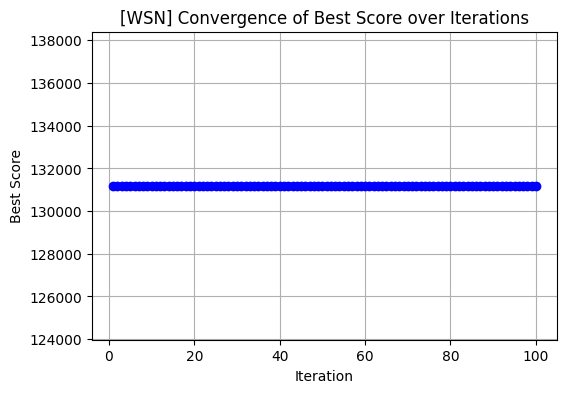

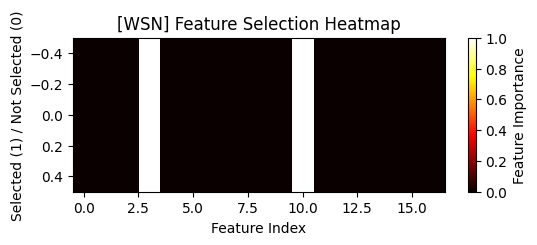



Mean Best Score: 131190.0
Standard Deviation of Best Score: 0.0
Mean Classification Accuracy: 0.6317516835668394
Standard Deviation of Classification Accuracy: 0.0032973598208848815



In [9]:
random_state = 1922
np.random.seed(random_state)

def load_data(file_path):
    data = pd.read_csv(file_path)
    features = data.iloc[:, 1:-1].copy()  # Explicitly create a copy of the DataFrame
    labels = data.iloc[:, -1].values
    encoder = LabelEncoder()

    # Now using .loc to ensure modification is done safely
    for col in features.columns:
        if features[col].dtype == 'object':
            features.loc[:, col] = encoder.fit_transform(features[col])

    features = features.values
    return features, labels

features, labels = load_data(file_path)

# Standardize features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# PSOVA1 Parameters
w = 0.7
c1 = 1.2  # Cognitive constant
c2 = 1.8  # Social constant
max_iter = 100
swarm_size = 30
pswitch = 0.5

# Objective Function for PSOVA1
def objective_function(x, features, labels):
    selected_features = features[:, x.astype(bool)]
    score = np.sum(np.square(selected_features)) if selected_features.size > 0 else 0
    penalty = 1000 * np.sum(x)
    return score + penalty

# Particle initialization
def initialize_particles(dim, swarm_size):
    positions = (np.random.rand(swarm_size, dim) < 0.5).astype(int)
    velocities = np.random.uniform(-1, 1, (swarm_size, dim))
    return positions, velocities

# Equation 1: Velocity update with rectified personal and global best signals
'''
[1.1] Rectified (non-negative) personal best influence
[1.2] Rectified (non-negative) global best influence
The velocity update here uses the best positions, both personal best (pbest) and global best (gbest),
and adjusts them dynamically during the optimization process.
This rectifies the influence of global and personal best signals.
'''
def update_velocity(velocity, position, pbest, gbest, c1, c2):
    r1, r2 = np.random.rand(*position.shape[1:]), np.random.rand(*position.shape[1:])
    inertia = w * velocity
    cognitive = c1 * r1 * np.maximum(pbest - position, 0)  # [1.1]
    social = c2 * r2 * np.maximum(gbest - position, 0)     # [1.2]
    return inertia + cognitive + social

# Equation 2: Position update
def update_position(position, velocity):
    new_position = position + np.round(velocity).astype(int)
    return (new_position > 0).astype(int)

# Equation 3: Gaussian Leader Enhancement
'''
[2] Gaussian distribution based swarm leader enhancement
The global best (leader) is enhanced using Gaussian distribution to fine-tune the search.
This approach helps in exploring the search space and potentially avoiding local optima.
'''
def gaussian_leader_enhancement(gbest, upper_bound, lower_bound):
    alpha = 0.1
    skewness = np.random.choice([-1, 0, 1])
    return gbest + alpha * np.random.normal(skewness) * (upper_bound - lower_bound)

# Equation 4: Mirroring-based Mutation
'''
[4] Mirroring-based mutation operation
Mirroring-based Mutation is a type of mutation operation often used in optimization algorithms 
to improve the diversity of solutions and escape local optima.
'''
def mirroring_mutation(gbest):
    mutation_probability = 0.1
    new_solution = np.where(np.random.rand(gbest.shape[0]) < mutation_probability, ~gbest.astype(bool), gbest)
    return new_solution.astype(int)

# Equations 5-6: Differential Evolution-based Mutation
'''
[4] Differential Evolution mutation for worst solution improvement
Differential Evolution (DE) mutation and mirroring strategies are used to improve the worst solutions.
This helps diversify the swarm and avoid stagnation at local optima.
'''
def de_mutation(pbest1, pbest2, pbest3):
    F = np.random.rand()
    donor = pbest1 ^ (pbest2 ^ pbest3)
    return donor

# Equation 7: Annealing Schedule for Acceptance
def annealing_acceptance(delta_f, temperature):
    value = -delta_f / temperature
    value = np.clip(value, -709, 709)
    return np.exp(value) > np.random.rand()

# Equation 11: Spiral-based Local Exploitation
'''
[5] Spiral search based local exploitation
A spiral pattern search mechanism for local exploitation (fine-tuning the solutions) is employed here.
It involves adjusting particle positions according to a spiral function for better convergence.
'''
def spiral_search(gbest, particle_position):
    l = np.random.uniform(-1, 1)
    D = np.abs(gbest - particle_position)
    return D * np.exp(l) * np.cos(2 * np.pi * l) + gbest

# Main PSOVA1 algorithm
def PSOVA1(features, labels, c1, c2, max_iter=100, swarm_size=30):
    dim = features.shape[1]
    positions, velocities = initialize_particles(dim, swarm_size)
    pbest_positions = np.copy(positions)
    pbest_scores = np.array([objective_function(p, features, labels) for p in pbest_positions])
    gbest_position = pbest_positions[np.argmin(pbest_scores)]
    gbest_score = np.min(pbest_scores)

    best_scores_over_time = []
    temperature = 1.0

    for iteration in range(max_iter):
        for i in range(swarm_size):
            if pbest_scores[i] < gbest_score:
                gbest_position = pbest_positions[i]
                gbest_score = pbest_scores[i]

        for i in range(swarm_size):
            velocities[i] = update_velocity(velocities[i], positions[i], pbest_positions[i], gbest_position, c1, c2)
            positions[i] = update_position(positions[i], velocities[i])

            fitness = objective_function(positions[i], features, labels)
            if fitness < pbest_scores[i]:
                pbest_positions[i] = positions[i]
                pbest_scores[i] = fitness
            if fitness < gbest_score:
                gbest_position = positions[i]
                gbest_score = fitness

        best_scores_over_time.append(gbest_score)
        print(f"Iteration {iteration + 1}: Best score = {gbest_score}")
        temperature *= 0.9

    return gbest_position, gbest_score, best_scores_over_time

# Classification accuracy calculation
def calculate_accuracy(features, labels, best_position, num_trials=10):
    accuracies = []
    selected_features = features[:, best_position.astype(bool)]

    for _ in range(num_trials):
        X_train, X_test, y_train, y_test = train_test_split(selected_features, labels, test_size=0.2, random_state=None)
        classifier = LogisticRegression(max_iter=500)
        classifier.fit(X_train, y_train)
        predictions = classifier.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        accuracies.append(accuracy)

    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    return mean_accuracy, std_accuracy

# Run PSOVA1 on Parkinson's dataset and capture best score over time
best_position, best_score, best_scores_over_time = PSOVA1(features, labels, c1, c2, max_iter, swarm_size)
mean_accuracy, std_accuracy = calculate_accuracy(features, labels, best_position)

# Calculate mean and standard deviation of best scores
mean_score = np.mean(best_scores_over_time)
std_score = np.std(best_scores_over_time)

# Visualization of best score over iterations
print("")
print("="*110)
plt.figure(figsize=(6, 4))
plt.plot(range(1, max_iter + 1), best_scores_over_time, marker='o', color='b')
plt.xlabel('Iteration')
plt.ylabel('Best Score')
plt.title('[WSN] Convergence of Best Score over Iterations')
plt.grid()
plt.show()

# Visualize best position in a feature heatmap
plt.figure(figsize=(6, 2))
plt.imshow(best_position.reshape(1, -1), cmap='hot', aspect='auto')
plt.colorbar(label='Feature Importance')
plt.title('[WSN] Feature Selection Heatmap')
plt.xlabel('Feature Index')
plt.ylabel('Selected (1) / Not Selected (0)')
plt.show()

# Print results
print("")
print("="*110)
print("")
print("Mean Best Score:", mean_score)
print("Standard Deviation of Best Score:", std_score)
print("Mean Classification Accuracy:", mean_accuracy)
print("Standard Deviation of Classification Accuracy:", std_accuracy)
print("")
print("="*110)
#21.0s

In [6]:
import optuna

def objective(trial):
    c1 = trial.suggest_float("c1", 0.5, 2.0)
    c2 = trial.suggest_float("c2", 0.5, 2.0)
    swarm_size = trial.suggest_int("swarm_size", 10, 50)
    
    # Run PSOVA1
    best_position, best_score, best_scores_over_time = PSOVA1(features, labels, c1, c2, 100, swarm_size)
    mean_accuracy, std_accuracy = calculate_accuracy(features, labels, best_position)
    
    # Define objective value (smaller is better)
    return best_score - mean_accuracy  # Adjust weights if necessary

# Run optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Best parameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)


[I 2024-11-26 21:41:26,797] A new study created in memory with name: no-name-ca0c4623-2ab8-4b90-bd4f-42dfe3ee4104


Iteration 1: Best score = 131190.0
Iteration 2: Best score = 131190.0
Iteration 3: Best score = 131190.0
Iteration 4: Best score = 131190.0
Iteration 5: Best score = 131190.0
Iteration 6: Best score = 131190.0
Iteration 7: Best score = 131190.0
Iteration 8: Best score = 131190.0
Iteration 9: Best score = 131190.0
Iteration 10: Best score = 131190.0
Iteration 11: Best score = 131190.0
Iteration 12: Best score = 131190.0
Iteration 13: Best score = 131190.0
Iteration 14: Best score = 131190.0
Iteration 15: Best score = 131190.0
Iteration 16: Best score = 131190.0
Iteration 17: Best score = 131190.0
Iteration 18: Best score = 131190.0
Iteration 19: Best score = 131190.0
Iteration 20: Best score = 131190.0
Iteration 21: Best score = 131190.0
Iteration 22: Best score = 131190.0
Iteration 23: Best score = 131190.0
Iteration 24: Best score = 131190.0
Iteration 25: Best score = 131190.0
Iteration 26: Best score = 131190.0
Iteration 27: Best score = 131190.0
Iteration 28: Best score = 131190.0
I

[I 2024-11-26 21:41:54,729] Trial 0 finished with value: 131189.20773279667 and parameters: {'c1': 1.8244441066704415, 'c2': 0.5378404527576017, 'swarm_size': 45}. Best is trial 0 with value: 131189.20773279667.


Iteration 1: Best score = 393570.00000000006
Iteration 2: Best score = 393570.00000000006
Iteration 3: Best score = 393570.00000000006
Iteration 4: Best score = 393570.00000000006
Iteration 5: Best score = 393570.00000000006
Iteration 6: Best score = 393570.00000000006
Iteration 7: Best score = 393570.00000000006
Iteration 8: Best score = 393570.00000000006
Iteration 9: Best score = 393570.00000000006
Iteration 10: Best score = 393570.00000000006
Iteration 11: Best score = 393570.00000000006
Iteration 12: Best score = 393570.00000000006
Iteration 13: Best score = 393570.00000000006
Iteration 14: Best score = 393570.00000000006
Iteration 15: Best score = 393570.00000000006
Iteration 16: Best score = 393570.00000000006
Iteration 17: Best score = 393570.00000000006
Iteration 18: Best score = 393570.00000000006
Iteration 19: Best score = 393570.00000000006
Iteration 20: Best score = 393570.00000000006
Iteration 21: Best score = 393570.00000000006
Iteration 22: Best score = 393570.000000000

[I 2024-11-26 21:42:14,473] Trial 1 finished with value: 393569.11781097617 and parameters: {'c1': 1.2397793121803513, 'c2': 1.1122651244911614, 'swarm_size': 12}. Best is trial 0 with value: 131189.20773279667.


Iteration 1: Best score = 327975.00000000006
Iteration 2: Best score = 327975.00000000006
Iteration 3: Best score = 327975.00000000006
Iteration 4: Best score = 327975.00000000006
Iteration 5: Best score = 327975.00000000006
Iteration 6: Best score = 327975.00000000006
Iteration 7: Best score = 327975.00000000006
Iteration 8: Best score = 327975.00000000006
Iteration 9: Best score = 327975.00000000006
Iteration 10: Best score = 327975.00000000006
Iteration 11: Best score = 327975.00000000006
Iteration 12: Best score = 327975.00000000006
Iteration 13: Best score = 327975.00000000006
Iteration 14: Best score = 327975.00000000006
Iteration 15: Best score = 327975.00000000006
Iteration 16: Best score = 327975.00000000006
Iteration 17: Best score = 327975.00000000006
Iteration 18: Best score = 327975.00000000006
Iteration 19: Best score = 327975.00000000006
Iteration 20: Best score = 327975.00000000006
Iteration 21: Best score = 327975.00000000006
Iteration 22: Best score = 327975.000000000

[I 2024-11-26 21:42:39,079] Trial 2 finished with value: 327974.19674123387 and parameters: {'c1': 0.7917393049863491, 'c2': 0.526469857774737, 'swarm_size': 30}. Best is trial 0 with value: 131189.20773279667.


Iteration 1: Best score = 262380.0
Iteration 2: Best score = 262380.0
Iteration 3: Best score = 262380.0
Iteration 4: Best score = 262380.0
Iteration 5: Best score = 262380.0
Iteration 6: Best score = 262380.0
Iteration 7: Best score = 262380.0
Iteration 8: Best score = 262380.0
Iteration 9: Best score = 262380.0
Iteration 10: Best score = 262380.0
Iteration 11: Best score = 262380.0
Iteration 12: Best score = 262380.0
Iteration 13: Best score = 262380.0
Iteration 14: Best score = 262380.0
Iteration 15: Best score = 262380.0
Iteration 16: Best score = 262380.0
Iteration 17: Best score = 262380.0
Iteration 18: Best score = 262380.0
Iteration 19: Best score = 262380.0
Iteration 20: Best score = 262380.0
Iteration 21: Best score = 262380.0
Iteration 22: Best score = 262380.0
Iteration 23: Best score = 262380.0
Iteration 24: Best score = 262380.0
Iteration 25: Best score = 262380.0
Iteration 26: Best score = 262380.0
Iteration 27: Best score = 262380.0
Iteration 28: Best score = 262380.0
I

[I 2024-11-26 21:42:55,452] Trial 3 finished with value: 262379.2907423175 and parameters: {'c1': 1.2952458130896534, 'c2': 0.7124904311973, 'swarm_size': 21}. Best is trial 0 with value: 131189.20773279667.


Iteration 1: Best score = 327975.00000000006
Iteration 2: Best score = 327975.00000000006
Iteration 3: Best score = 327975.00000000006
Iteration 4: Best score = 327975.00000000006
Iteration 5: Best score = 327975.00000000006
Iteration 6: Best score = 327975.00000000006
Iteration 7: Best score = 327975.00000000006
Iteration 8: Best score = 327975.00000000006
Iteration 9: Best score = 327975.00000000006
Iteration 10: Best score = 327975.00000000006
Iteration 11: Best score = 327975.00000000006
Iteration 12: Best score = 327975.00000000006
Iteration 13: Best score = 327975.00000000006
Iteration 14: Best score = 327975.00000000006
Iteration 15: Best score = 327975.00000000006
Iteration 16: Best score = 327975.00000000006
Iteration 17: Best score = 327975.00000000006
Iteration 18: Best score = 327975.00000000006
Iteration 19: Best score = 327975.00000000006
Iteration 20: Best score = 327975.00000000006
Iteration 21: Best score = 327975.00000000006
Iteration 22: Best score = 327975.000000000

[I 2024-11-26 21:43:23,370] Trial 4 finished with value: 327974.23121758655 and parameters: {'c1': 1.1932906750273917, 'c2': 1.031676718203751, 'swarm_size': 31}. Best is trial 0 with value: 131189.20773279667.


Iteration 1: Best score = 459164.9999999999
Iteration 2: Best score = 459164.9999999999
Iteration 3: Best score = 459164.9999999999
Iteration 4: Best score = 459164.9999999999
Iteration 5: Best score = 459164.9999999999
Iteration 6: Best score = 459164.9999999999
Iteration 7: Best score = 459164.9999999999
Iteration 8: Best score = 459164.9999999999
Iteration 9: Best score = 459164.9999999999
Iteration 10: Best score = 459164.9999999999
Iteration 11: Best score = 459164.9999999999
Iteration 12: Best score = 459164.9999999999
Iteration 13: Best score = 459164.9999999999
Iteration 14: Best score = 459164.9999999999
Iteration 15: Best score = 459164.9999999999
Iteration 16: Best score = 459164.9999999999
Iteration 17: Best score = 459164.9999999999
Iteration 18: Best score = 459164.9999999999
Iteration 19: Best score = 459164.9999999999
Iteration 20: Best score = 459164.9999999999
Iteration 21: Best score = 459164.9999999999
Iteration 22: Best score = 459164.9999999999
Iteration 23: Best 

[I 2024-11-26 21:43:41,181] Trial 5 finished with value: 459164.1950073534 and parameters: {'c1': 1.4221437738641005, 'c2': 1.6306365717050413, 'swarm_size': 13}. Best is trial 0 with value: 131189.20773279667.


Iteration 1: Best score = 262380.0
Iteration 2: Best score = 262380.0
Iteration 3: Best score = 262380.0
Iteration 4: Best score = 262380.0
Iteration 5: Best score = 262380.0
Iteration 6: Best score = 262380.0
Iteration 7: Best score = 262380.0
Iteration 8: Best score = 262380.0
Iteration 9: Best score = 262380.0
Iteration 10: Best score = 262380.0
Iteration 11: Best score = 262380.0
Iteration 12: Best score = 262380.0
Iteration 13: Best score = 262380.0
Iteration 14: Best score = 262380.0
Iteration 15: Best score = 262380.0
Iteration 16: Best score = 262380.0
Iteration 17: Best score = 262380.0
Iteration 18: Best score = 262380.0
Iteration 19: Best score = 262380.0
Iteration 20: Best score = 262380.0
Iteration 21: Best score = 262380.0
Iteration 22: Best score = 262380.0
Iteration 23: Best score = 262380.0
Iteration 24: Best score = 262380.0
Iteration 25: Best score = 262380.0
Iteration 26: Best score = 262380.0
Iteration 27: Best score = 262380.0
Iteration 28: Best score = 262380.0
I

[I 2024-11-26 21:43:54,877] Trial 6 finished with value: 262379.3008204969 and parameters: {'c1': 1.6605752955368374, 'c2': 1.3107224346420063, 'swarm_size': 13}. Best is trial 0 with value: 131189.20773279667.


Iteration 1: Best score = 393570.00000000006
Iteration 2: Best score = 393570.00000000006
Iteration 3: Best score = 393570.00000000006
Iteration 4: Best score = 393570.00000000006
Iteration 5: Best score = 393570.00000000006
Iteration 6: Best score = 393570.00000000006
Iteration 7: Best score = 393570.00000000006
Iteration 8: Best score = 393570.00000000006
Iteration 9: Best score = 393570.00000000006
Iteration 10: Best score = 393570.00000000006
Iteration 11: Best score = 393570.00000000006
Iteration 12: Best score = 393570.00000000006
Iteration 13: Best score = 393570.00000000006
Iteration 14: Best score = 393570.00000000006
Iteration 15: Best score = 393570.00000000006
Iteration 16: Best score = 393570.00000000006
Iteration 17: Best score = 393570.00000000006
Iteration 18: Best score = 393570.00000000006
Iteration 19: Best score = 393570.00000000006
Iteration 20: Best score = 393570.00000000006
Iteration 21: Best score = 393570.00000000006
Iteration 22: Best score = 393570.000000000

[I 2024-11-26 21:44:24,271] Trial 7 finished with value: 393569.22319064947 and parameters: {'c1': 1.3709502787542835, 'c2': 1.4444547133592849, 'swarm_size': 25}. Best is trial 0 with value: 131189.20773279667.


Iteration 1: Best score = 327975.00000000006
Iteration 2: Best score = 327975.00000000006
Iteration 3: Best score = 327975.00000000006
Iteration 4: Best score = 327975.00000000006
Iteration 5: Best score = 327975.00000000006
Iteration 6: Best score = 327975.00000000006
Iteration 7: Best score = 327975.00000000006
Iteration 8: Best score = 327975.00000000006
Iteration 9: Best score = 327975.00000000006
Iteration 10: Best score = 327975.00000000006
Iteration 11: Best score = 327975.00000000006
Iteration 12: Best score = 327975.00000000006
Iteration 13: Best score = 327975.00000000006
Iteration 14: Best score = 327975.00000000006
Iteration 15: Best score = 327975.00000000006
Iteration 16: Best score = 327975.00000000006
Iteration 17: Best score = 327975.00000000006
Iteration 18: Best score = 327975.00000000006
Iteration 19: Best score = 327975.00000000006
Iteration 20: Best score = 327975.00000000006
Iteration 21: Best score = 327975.00000000006
Iteration 22: Best score = 327975.000000000

[I 2024-11-26 21:44:58,922] Trial 8 finished with value: 327974.21985447797 and parameters: {'c1': 1.7116752939235322, 'c2': 1.6093871216632252, 'swarm_size': 39}. Best is trial 0 with value: 131189.20773279667.


Iteration 1: Best score = 327974.99999999994
Iteration 2: Best score = 327974.99999999994
Iteration 3: Best score = 327974.99999999994
Iteration 4: Best score = 327974.99999999994
Iteration 5: Best score = 327974.99999999994
Iteration 6: Best score = 327974.99999999994
Iteration 7: Best score = 327974.99999999994
Iteration 8: Best score = 327974.99999999994
Iteration 9: Best score = 327974.99999999994
Iteration 10: Best score = 327974.99999999994
Iteration 11: Best score = 327974.99999999994
Iteration 12: Best score = 327974.99999999994
Iteration 13: Best score = 327974.99999999994
Iteration 14: Best score = 327974.99999999994
Iteration 15: Best score = 327974.99999999994
Iteration 16: Best score = 327974.99999999994
Iteration 17: Best score = 327974.99999999994
Iteration 18: Best score = 327974.99999999994
Iteration 19: Best score = 327974.99999999994
Iteration 20: Best score = 327974.99999999994
Iteration 21: Best score = 327974.99999999994
Iteration 22: Best score = 327974.999999999

[I 2024-11-26 21:45:16,302] Trial 9 finished with value: 327974.1711897205 and parameters: {'c1': 0.7939482640229809, 'c2': 0.8587777352014906, 'swarm_size': 18}. Best is trial 0 with value: 131189.20773279667.


Iteration 1: Best score = 327974.99999999994
Iteration 2: Best score = 327974.99999999994
Iteration 3: Best score = 327974.99999999994
Iteration 4: Best score = 327974.99999999994
Iteration 5: Best score = 327974.99999999994
Iteration 6: Best score = 327974.99999999994
Iteration 7: Best score = 327974.99999999994
Iteration 8: Best score = 327974.99999999994
Iteration 9: Best score = 327974.99999999994
Iteration 10: Best score = 327974.99999999994
Iteration 11: Best score = 327974.99999999994
Iteration 12: Best score = 327974.99999999994
Iteration 13: Best score = 327974.99999999994
Iteration 14: Best score = 327974.99999999994
Iteration 15: Best score = 327974.99999999994
Iteration 16: Best score = 327974.99999999994
Iteration 17: Best score = 327974.99999999994
Iteration 18: Best score = 327974.99999999994
Iteration 19: Best score = 327974.99999999994
Iteration 20: Best score = 327974.99999999994
Iteration 21: Best score = 327974.99999999994
Iteration 22: Best score = 327974.999999999

[I 2024-11-26 21:45:42,042] Trial 10 finished with value: 327974.24798359 and parameters: {'c1': 1.9921002001709844, 'c2': 1.953684910081485, 'swarm_size': 46}. Best is trial 0 with value: 131189.20773279667.


Iteration 1: Best score = 262379.9999999999
Iteration 2: Best score = 262379.9999999999
Iteration 3: Best score = 262379.9999999999
Iteration 4: Best score = 262379.9999999999
Iteration 5: Best score = 262379.9999999999
Iteration 6: Best score = 262379.9999999999
Iteration 7: Best score = 262379.9999999999
Iteration 8: Best score = 262379.9999999999
Iteration 9: Best score = 262379.9999999999
Iteration 10: Best score = 262379.9999999999
Iteration 11: Best score = 262379.9999999999
Iteration 12: Best score = 262379.9999999999
Iteration 13: Best score = 262379.9999999999
Iteration 14: Best score = 262379.9999999999
Iteration 15: Best score = 262379.9999999999
Iteration 16: Best score = 262379.9999999999
Iteration 17: Best score = 262379.9999999999
Iteration 18: Best score = 262379.9999999999
Iteration 19: Best score = 262379.9999999999
Iteration 20: Best score = 262379.9999999999
Iteration 21: Best score = 262379.9999999999
Iteration 22: Best score = 262379.9999999999
Iteration 23: Best 

[I 2024-11-26 21:46:06,548] Trial 11 finished with value: 262379.2443687591 and parameters: {'c1': 0.5460725601221823, 'c2': 0.62145014518952, 'swarm_size': 49}. Best is trial 0 with value: 131189.20773279667.


Iteration 1: Best score = 262380.0
Iteration 2: Best score = 262380.0
Iteration 3: Best score = 262380.0
Iteration 4: Best score = 262380.0
Iteration 5: Best score = 262380.0
Iteration 6: Best score = 262380.0
Iteration 7: Best score = 262380.0
Iteration 8: Best score = 262380.0
Iteration 9: Best score = 262380.0
Iteration 10: Best score = 262380.0
Iteration 11: Best score = 262380.0
Iteration 12: Best score = 262380.0
Iteration 13: Best score = 262380.0
Iteration 14: Best score = 262380.0
Iteration 15: Best score = 262380.0
Iteration 16: Best score = 262380.0
Iteration 17: Best score = 262380.0
Iteration 18: Best score = 262380.0
Iteration 19: Best score = 262380.0
Iteration 20: Best score = 262380.0
Iteration 21: Best score = 262380.0
Iteration 22: Best score = 262380.0
Iteration 23: Best score = 262380.0
Iteration 24: Best score = 262380.0
Iteration 25: Best score = 262380.0
Iteration 26: Best score = 262380.0
Iteration 27: Best score = 262380.0
Iteration 28: Best score = 262380.0
I

[I 2024-11-26 21:46:38,708] Trial 12 finished with value: 262379.24796036846 and parameters: {'c1': 0.5337825988054313, 'c2': 0.5750059830364841, 'swarm_size': 50}. Best is trial 0 with value: 131189.20773279667.


Iteration 1: Best score = 65594.99999999999
Iteration 2: Best score = 65594.99999999999
Iteration 3: Best score = 65594.99999999999
Iteration 4: Best score = 65594.99999999999
Iteration 5: Best score = 65594.99999999999
Iteration 6: Best score = 65594.99999999999
Iteration 7: Best score = 65594.99999999999
Iteration 8: Best score = 65594.99999999999
Iteration 9: Best score = 65594.99999999999
Iteration 10: Best score = 65594.99999999999
Iteration 11: Best score = 65594.99999999999
Iteration 12: Best score = 65594.99999999999
Iteration 13: Best score = 65594.99999999999
Iteration 14: Best score = 65594.99999999999
Iteration 15: Best score = 65594.99999999999
Iteration 16: Best score = 65594.99999999999
Iteration 17: Best score = 65594.99999999999
Iteration 18: Best score = 65594.99999999999
Iteration 19: Best score = 65594.99999999999
Iteration 20: Best score = 65594.99999999999
Iteration 21: Best score = 65594.99999999999
Iteration 22: Best score = 65594.99999999999
Iteration 23: Best 

[I 2024-11-26 21:46:57,461] Trial 13 finished with value: 65594.39823515751 and parameters: {'c1': 1.9799698316601977, 'c2': 0.8243163433594834, 'swarm_size': 42}. Best is trial 13 with value: 65594.39823515751.


Iteration 1: Best score = 196784.99999999994
Iteration 2: Best score = 196784.99999999994
Iteration 3: Best score = 196784.99999999994
Iteration 4: Best score = 196784.99999999994
Iteration 5: Best score = 196784.99999999994
Iteration 6: Best score = 196784.99999999994
Iteration 7: Best score = 196784.99999999994
Iteration 8: Best score = 196784.99999999994
Iteration 9: Best score = 196784.99999999994
Iteration 10: Best score = 196784.99999999994
Iteration 11: Best score = 196784.99999999994
Iteration 12: Best score = 196784.99999999994
Iteration 13: Best score = 196784.99999999994
Iteration 14: Best score = 196784.99999999994
Iteration 15: Best score = 196784.99999999994
Iteration 16: Best score = 196784.99999999994
Iteration 17: Best score = 196784.99999999994
Iteration 18: Best score = 196784.99999999994
Iteration 19: Best score = 196784.99999999994
Iteration 20: Best score = 196784.99999999994
Iteration 21: Best score = 196784.99999999994
Iteration 22: Best score = 196784.999999999

[I 2024-11-26 21:47:21,876] Trial 14 finished with value: 196784.2969966715 and parameters: {'c1': 1.9056295016720666, 'c2': 0.8634271736387885, 'swarm_size': 41}. Best is trial 13 with value: 65594.39823515751.


Iteration 1: Best score = 327974.99999999994
Iteration 2: Best score = 327974.99999999994
Iteration 3: Best score = 327974.99999999994
Iteration 4: Best score = 327974.99999999994
Iteration 5: Best score = 327974.99999999994
Iteration 6: Best score = 327974.99999999994
Iteration 7: Best score = 327974.99999999994
Iteration 8: Best score = 327974.99999999994
Iteration 9: Best score = 327974.99999999994
Iteration 10: Best score = 327974.99999999994
Iteration 11: Best score = 327974.99999999994
Iteration 12: Best score = 327974.99999999994
Iteration 13: Best score = 327974.99999999994
Iteration 14: Best score = 327974.99999999994
Iteration 15: Best score = 327974.99999999994
Iteration 16: Best score = 327974.99999999994
Iteration 17: Best score = 327974.99999999994
Iteration 18: Best score = 327974.99999999994
Iteration 19: Best score = 327974.99999999994
Iteration 20: Best score = 327974.99999999994
Iteration 21: Best score = 327974.99999999994
Iteration 22: Best score = 327974.999999999

[I 2024-11-26 21:47:51,494] Trial 15 finished with value: 327974.21894109447 and parameters: {'c1': 1.760205524711367, 'c2': 0.8079202509493473, 'swarm_size': 39}. Best is trial 13 with value: 65594.39823515751.


Iteration 1: Best score = 327975.0
Iteration 2: Best score = 327975.0
Iteration 3: Best score = 327975.0
Iteration 4: Best score = 327975.0
Iteration 5: Best score = 327975.0
Iteration 6: Best score = 327975.0
Iteration 7: Best score = 327975.0
Iteration 8: Best score = 327975.0
Iteration 9: Best score = 327975.0
Iteration 10: Best score = 327975.0
Iteration 11: Best score = 327975.0
Iteration 12: Best score = 327975.0
Iteration 13: Best score = 327975.0
Iteration 14: Best score = 327975.0
Iteration 15: Best score = 327975.0
Iteration 16: Best score = 327975.0
Iteration 17: Best score = 327975.0
Iteration 18: Best score = 327975.0
Iteration 19: Best score = 327975.0
Iteration 20: Best score = 327975.0
Iteration 21: Best score = 327975.0
Iteration 22: Best score = 327975.0
Iteration 23: Best score = 327975.0
Iteration 24: Best score = 327975.0
Iteration 25: Best score = 327975.0
Iteration 26: Best score = 327975.0
Iteration 27: Best score = 327975.0
Iteration 28: Best score = 327975.0
I

[I 2024-11-26 21:48:24,421] Trial 16 finished with value: 327974.16681631707 and parameters: {'c1': 1.5086895341498678, 'c2': 1.026283730747808, 'swarm_size': 43}. Best is trial 13 with value: 65594.39823515751.


Iteration 1: Best score = 262380.0
Iteration 2: Best score = 262380.0
Iteration 3: Best score = 262380.0
Iteration 4: Best score = 262380.0
Iteration 5: Best score = 262380.0
Iteration 6: Best score = 262380.0
Iteration 7: Best score = 262380.0
Iteration 8: Best score = 262380.0
Iteration 9: Best score = 262380.0
Iteration 10: Best score = 262380.0
Iteration 11: Best score = 262380.0
Iteration 12: Best score = 262380.0
Iteration 13: Best score = 262380.0
Iteration 14: Best score = 262380.0
Iteration 15: Best score = 262380.0
Iteration 16: Best score = 262380.0
Iteration 17: Best score = 262380.0
Iteration 18: Best score = 262380.0
Iteration 19: Best score = 262380.0
Iteration 20: Best score = 262380.0
Iteration 21: Best score = 262380.0
Iteration 22: Best score = 262380.0
Iteration 23: Best score = 262380.0
Iteration 24: Best score = 262380.0
Iteration 25: Best score = 262380.0
Iteration 26: Best score = 262380.0
Iteration 27: Best score = 262380.0
Iteration 28: Best score = 262380.0
I

[I 2024-11-26 21:48:44,437] Trial 17 finished with value: 262379.3010294915 and parameters: {'c1': 1.848916033995375, 'c2': 0.7266082909738655, 'swarm_size': 33}. Best is trial 13 with value: 65594.39823515751.


Iteration 1: Best score = 262380.0
Iteration 2: Best score = 262380.0
Iteration 3: Best score = 262380.0
Iteration 4: Best score = 262380.0
Iteration 5: Best score = 262380.0
Iteration 6: Best score = 262380.0
Iteration 7: Best score = 262380.0
Iteration 8: Best score = 262380.0
Iteration 9: Best score = 262380.0
Iteration 10: Best score = 262380.0
Iteration 11: Best score = 262380.0
Iteration 12: Best score = 262380.0
Iteration 13: Best score = 262380.0
Iteration 14: Best score = 262380.0
Iteration 15: Best score = 262380.0
Iteration 16: Best score = 262380.0
Iteration 17: Best score = 262380.0
Iteration 18: Best score = 262380.0
Iteration 19: Best score = 262380.0
Iteration 20: Best score = 262380.0
Iteration 21: Best score = 262380.0
Iteration 22: Best score = 262380.0
Iteration 23: Best score = 262380.0
Iteration 24: Best score = 262380.0
Iteration 25: Best score = 262380.0
Iteration 26: Best score = 262380.0
Iteration 27: Best score = 262380.0
Iteration 28: Best score = 262380.0
I

[I 2024-11-26 21:49:15,054] Trial 18 finished with value: 262379.2311711433 and parameters: {'c1': 1.5919843481092721, 'c2': 0.9488539085025975, 'swarm_size': 35}. Best is trial 13 with value: 65594.39823515751.


Iteration 1: Best score = 196784.9999999999
Iteration 2: Best score = 196784.9999999999
Iteration 3: Best score = 196784.9999999999
Iteration 4: Best score = 196784.9999999999
Iteration 5: Best score = 196784.9999999999
Iteration 6: Best score = 196784.9999999999
Iteration 7: Best score = 196784.9999999999
Iteration 8: Best score = 196784.9999999999
Iteration 9: Best score = 196784.9999999999
Iteration 10: Best score = 196784.9999999999
Iteration 11: Best score = 196784.9999999999
Iteration 12: Best score = 196784.9999999999
Iteration 13: Best score = 196784.9999999999
Iteration 14: Best score = 196784.9999999999
Iteration 15: Best score = 196784.9999999999
Iteration 16: Best score = 196784.9999999999
Iteration 17: Best score = 196784.9999999999
Iteration 18: Best score = 196784.9999999999
Iteration 19: Best score = 196784.9999999999
Iteration 20: Best score = 196784.9999999999
Iteration 21: Best score = 196784.9999999999
Iteration 22: Best score = 196784.9999999999
Iteration 23: Best 

[I 2024-11-26 21:49:43,422] Trial 19 finished with value: 196784.21383233988 and parameters: {'c1': 0.9799915680012269, 'c2': 0.5045120570310391, 'swarm_size': 45}. Best is trial 13 with value: 65594.39823515751.


Iteration 1: Best score = 196784.99999999997
Iteration 2: Best score = 196784.99999999997
Iteration 3: Best score = 196784.99999999997
Iteration 4: Best score = 196784.99999999997
Iteration 5: Best score = 196784.99999999997
Iteration 6: Best score = 196784.99999999997
Iteration 7: Best score = 196784.99999999997
Iteration 8: Best score = 196784.99999999997
Iteration 9: Best score = 196784.99999999997
Iteration 10: Best score = 196784.99999999997
Iteration 11: Best score = 196784.99999999997
Iteration 12: Best score = 196784.99999999997
Iteration 13: Best score = 196784.99999999997
Iteration 14: Best score = 196784.99999999997
Iteration 15: Best score = 196784.99999999997
Iteration 16: Best score = 196784.99999999997
Iteration 17: Best score = 196784.99999999997
Iteration 18: Best score = 196784.99999999997
Iteration 19: Best score = 196784.99999999997
Iteration 20: Best score = 196784.99999999997
Iteration 21: Best score = 196784.99999999997
Iteration 22: Best score = 196784.999999999

[I 2024-11-26 21:50:03,572] Trial 20 finished with value: 196784.2612586113 and parameters: {'c1': 1.9397846057531076, 'c2': 1.2179334005545233, 'swarm_size': 35}. Best is trial 13 with value: 65594.39823515751.


Iteration 1: Best score = 196784.99999999994
Iteration 2: Best score = 196784.99999999994
Iteration 3: Best score = 196784.99999999994
Iteration 4: Best score = 196784.99999999994
Iteration 5: Best score = 196784.99999999994
Iteration 6: Best score = 196784.99999999994
Iteration 7: Best score = 196784.99999999994
Iteration 8: Best score = 196784.99999999994
Iteration 9: Best score = 196784.99999999994
Iteration 10: Best score = 196784.99999999994
Iteration 11: Best score = 196784.99999999994
Iteration 12: Best score = 196784.99999999994
Iteration 13: Best score = 196784.99999999994
Iteration 14: Best score = 196784.99999999994
Iteration 15: Best score = 196784.99999999994
Iteration 16: Best score = 196784.99999999994
Iteration 17: Best score = 196784.99999999994
Iteration 18: Best score = 196784.99999999994
Iteration 19: Best score = 196784.99999999994
Iteration 20: Best score = 196784.99999999994
Iteration 21: Best score = 196784.99999999994
Iteration 22: Best score = 196784.999999999

[I 2024-11-26 21:50:28,615] Trial 21 finished with value: 196784.3650669556 and parameters: {'c1': 1.0079168900133266, 'c2': 0.5057435102261334, 'swarm_size': 45}. Best is trial 13 with value: 65594.39823515751.


Iteration 1: Best score = 196784.9999999999
Iteration 2: Best score = 196784.9999999999
Iteration 3: Best score = 196784.9999999999
Iteration 4: Best score = 196784.9999999999
Iteration 5: Best score = 196784.9999999999
Iteration 6: Best score = 196784.9999999999
Iteration 7: Best score = 196784.9999999999
Iteration 8: Best score = 196784.9999999999
Iteration 9: Best score = 196784.9999999999
Iteration 10: Best score = 196784.9999999999
Iteration 11: Best score = 196784.9999999999
Iteration 12: Best score = 196784.9999999999
Iteration 13: Best score = 196784.9999999999
Iteration 14: Best score = 196784.9999999999
Iteration 15: Best score = 196784.9999999999
Iteration 16: Best score = 196784.9999999999
Iteration 17: Best score = 196784.9999999999
Iteration 18: Best score = 196784.9999999999
Iteration 19: Best score = 196784.9999999999
Iteration 20: Best score = 196784.9999999999
Iteration 21: Best score = 196784.9999999999
Iteration 22: Best score = 196784.9999999999
Iteration 23: Best 

[I 2024-11-26 21:50:58,204] Trial 22 finished with value: 196784.1665531387 and parameters: {'c1': 1.090374013858191, 'c2': 0.6845909337522742, 'swarm_size': 47}. Best is trial 13 with value: 65594.39823515751.


Iteration 1: Best score = 262380.0
Iteration 2: Best score = 262380.0
Iteration 3: Best score = 262380.0
Iteration 4: Best score = 262380.0
Iteration 5: Best score = 262380.0
Iteration 6: Best score = 262380.0
Iteration 7: Best score = 262380.0
Iteration 8: Best score = 262380.0
Iteration 9: Best score = 262380.0
Iteration 10: Best score = 262380.0
Iteration 11: Best score = 262380.0
Iteration 12: Best score = 262380.0
Iteration 13: Best score = 262380.0
Iteration 14: Best score = 262380.0
Iteration 15: Best score = 262380.0
Iteration 16: Best score = 262380.0
Iteration 17: Best score = 262380.0
Iteration 18: Best score = 262380.0
Iteration 19: Best score = 262380.0
Iteration 20: Best score = 262380.0
Iteration 21: Best score = 262380.0
Iteration 22: Best score = 262380.0
Iteration 23: Best score = 262380.0
Iteration 24: Best score = 262380.0
Iteration 25: Best score = 262380.0
Iteration 26: Best score = 262380.0
Iteration 27: Best score = 262380.0
Iteration 28: Best score = 262380.0
I

[I 2024-11-26 21:51:28,489] Trial 23 finished with value: 262379.27495936217 and parameters: {'c1': 1.0366965590793056, 'c2': 0.707723262199858, 'swarm_size': 48}. Best is trial 13 with value: 65594.39823515751.


Iteration 1: Best score = 262379.9999999999
Iteration 2: Best score = 262379.9999999999
Iteration 3: Best score = 262379.9999999999
Iteration 4: Best score = 262379.9999999999
Iteration 5: Best score = 262379.9999999999
Iteration 6: Best score = 262379.9999999999
Iteration 7: Best score = 262379.9999999999
Iteration 8: Best score = 262379.9999999999
Iteration 9: Best score = 262379.9999999999
Iteration 10: Best score = 262379.9999999999
Iteration 11: Best score = 262379.9999999999
Iteration 12: Best score = 262379.9999999999
Iteration 13: Best score = 262379.9999999999
Iteration 14: Best score = 262379.9999999999
Iteration 15: Best score = 262379.9999999999
Iteration 16: Best score = 262379.9999999999
Iteration 17: Best score = 262379.9999999999
Iteration 18: Best score = 262379.9999999999
Iteration 19: Best score = 262379.9999999999
Iteration 20: Best score = 262379.9999999999
Iteration 21: Best score = 262379.9999999999
Iteration 22: Best score = 262379.9999999999
Iteration 23: Best 

[I 2024-11-26 21:51:50,516] Trial 24 finished with value: 262379.34355600266 and parameters: {'c1': 1.806175316361006, 'c2': 0.6656524468570707, 'swarm_size': 38}. Best is trial 13 with value: 65594.39823515751.


Iteration 1: Best score = 262380.0
Iteration 2: Best score = 262380.0
Iteration 3: Best score = 262380.0
Iteration 4: Best score = 262380.0
Iteration 5: Best score = 262380.0
Iteration 6: Best score = 262380.0
Iteration 7: Best score = 262380.0
Iteration 8: Best score = 262380.0
Iteration 9: Best score = 262380.0
Iteration 10: Best score = 262380.0
Iteration 11: Best score = 262380.0
Iteration 12: Best score = 262380.0
Iteration 13: Best score = 262380.0
Iteration 14: Best score = 262380.0
Iteration 15: Best score = 262380.0
Iteration 16: Best score = 262380.0
Iteration 17: Best score = 262380.0
Iteration 18: Best score = 262380.0
Iteration 19: Best score = 262380.0
Iteration 20: Best score = 262380.0
Iteration 21: Best score = 262380.0
Iteration 22: Best score = 262380.0
Iteration 23: Best score = 262380.0
Iteration 24: Best score = 262380.0
Iteration 25: Best score = 262380.0
Iteration 26: Best score = 262380.0
Iteration 27: Best score = 262380.0
Iteration 28: Best score = 262380.0
I

[I 2024-11-26 21:52:16,349] Trial 25 finished with value: 262379.2604458549 and parameters: {'c1': 1.1449611267032012, 'c2': 0.814890412078037, 'swarm_size': 43}. Best is trial 13 with value: 65594.39823515751.


Iteration 1: Best score = 327975.00000000006
Iteration 2: Best score = 327975.00000000006
Iteration 3: Best score = 327975.00000000006
Iteration 4: Best score = 327975.00000000006
Iteration 5: Best score = 327975.00000000006
Iteration 6: Best score = 327975.00000000006
Iteration 7: Best score = 327975.00000000006
Iteration 8: Best score = 327975.00000000006
Iteration 9: Best score = 327975.00000000006
Iteration 10: Best score = 327975.00000000006
Iteration 11: Best score = 327975.00000000006
Iteration 12: Best score = 327975.00000000006
Iteration 13: Best score = 327975.00000000006
Iteration 14: Best score = 327975.00000000006
Iteration 15: Best score = 327975.00000000006
Iteration 16: Best score = 327975.00000000006
Iteration 17: Best score = 327975.00000000006
Iteration 18: Best score = 327975.00000000006
Iteration 19: Best score = 327975.00000000006
Iteration 20: Best score = 327975.00000000006
Iteration 21: Best score = 327975.00000000006
Iteration 22: Best score = 327975.000000000

[I 2024-11-26 21:52:43,988] Trial 26 finished with value: 327974.18297855876 and parameters: {'c1': 1.558254457407119, 'c2': 0.9486411373221131, 'swarm_size': 26}. Best is trial 13 with value: 65594.39823515751.


Iteration 1: Best score = 327975.0
Iteration 2: Best score = 327975.0
Iteration 3: Best score = 327975.0
Iteration 4: Best score = 327975.0
Iteration 5: Best score = 327975.0
Iteration 6: Best score = 327975.0
Iteration 7: Best score = 327975.0
Iteration 8: Best score = 327975.0
Iteration 9: Best score = 327975.0
Iteration 10: Best score = 327975.0
Iteration 11: Best score = 327975.0
Iteration 12: Best score = 327975.0
Iteration 13: Best score = 327975.0
Iteration 14: Best score = 327975.0
Iteration 15: Best score = 327975.0
Iteration 16: Best score = 327975.0
Iteration 17: Best score = 327975.0
Iteration 18: Best score = 327975.0
Iteration 19: Best score = 327975.0
Iteration 20: Best score = 327975.0
Iteration 21: Best score = 327975.0
Iteration 22: Best score = 327975.0
Iteration 23: Best score = 327975.0
Iteration 24: Best score = 327975.0
Iteration 25: Best score = 327975.0
Iteration 26: Best score = 327975.0
Iteration 27: Best score = 327975.0
Iteration 28: Best score = 327975.0
I

[I 2024-11-26 21:53:12,631] Trial 27 finished with value: 327974.255878938 and parameters: {'c1': 0.8015773521725841, 'c2': 0.6503319088149166, 'swarm_size': 42}. Best is trial 13 with value: 65594.39823515751.


Iteration 1: Best score = 196785.0
Iteration 2: Best score = 196785.0
Iteration 3: Best score = 196785.0
Iteration 4: Best score = 196785.0
Iteration 5: Best score = 196785.0
Iteration 6: Best score = 196785.0
Iteration 7: Best score = 196785.0
Iteration 8: Best score = 196785.0
Iteration 9: Best score = 196785.0
Iteration 10: Best score = 196785.0
Iteration 11: Best score = 196785.0
Iteration 12: Best score = 196785.0
Iteration 13: Best score = 196785.0
Iteration 14: Best score = 196785.0
Iteration 15: Best score = 196785.0
Iteration 16: Best score = 196785.0
Iteration 17: Best score = 196785.0
Iteration 18: Best score = 196785.0
Iteration 19: Best score = 196785.0
Iteration 20: Best score = 196785.0
Iteration 21: Best score = 196785.0
Iteration 22: Best score = 196785.0
Iteration 23: Best score = 196785.0
Iteration 24: Best score = 196785.0
Iteration 25: Best score = 196785.0
Iteration 26: Best score = 196785.0
Iteration 27: Best score = 196785.0
Iteration 28: Best score = 196785.0
I

[I 2024-11-26 21:53:36,899] Trial 28 finished with value: 196784.29162473875 and parameters: {'c1': 1.9947763468908497, 'c2': 1.1822633737871677, 'swarm_size': 47}. Best is trial 13 with value: 65594.39823515751.


Iteration 1: Best score = 327975.0
Iteration 2: Best score = 327975.0
Iteration 3: Best score = 327975.0
Iteration 4: Best score = 327975.0
Iteration 5: Best score = 327975.0
Iteration 6: Best score = 327975.0
Iteration 7: Best score = 327975.0
Iteration 8: Best score = 327975.0
Iteration 9: Best score = 327975.0
Iteration 10: Best score = 327975.0
Iteration 11: Best score = 327975.0
Iteration 12: Best score = 327975.0
Iteration 13: Best score = 327975.0
Iteration 14: Best score = 327975.0
Iteration 15: Best score = 327975.0
Iteration 16: Best score = 327975.0
Iteration 17: Best score = 327975.0
Iteration 18: Best score = 327975.0
Iteration 19: Best score = 327975.0
Iteration 20: Best score = 327975.0
Iteration 21: Best score = 327975.0
Iteration 22: Best score = 327975.0
Iteration 23: Best score = 327975.0
Iteration 24: Best score = 327975.0
Iteration 25: Best score = 327975.0
Iteration 26: Best score = 327975.0
Iteration 27: Best score = 327975.0
Iteration 28: Best score = 327975.0
I

[I 2024-11-26 21:54:03,950] Trial 29 finished with value: 327974.2873674433 and parameters: {'c1': 1.4611929081570665, 'c2': 0.757838804449426, 'swarm_size': 36}. Best is trial 13 with value: 65594.39823515751.


Iteration 1: Best score = 196785.00000000003
Iteration 2: Best score = 196785.00000000003
Iteration 3: Best score = 196785.00000000003
Iteration 4: Best score = 196785.00000000003
Iteration 5: Best score = 196785.00000000003
Iteration 6: Best score = 196785.00000000003
Iteration 7: Best score = 196785.00000000003
Iteration 8: Best score = 196785.00000000003
Iteration 9: Best score = 196785.00000000003
Iteration 10: Best score = 196785.00000000003
Iteration 11: Best score = 196785.00000000003
Iteration 12: Best score = 196785.00000000003
Iteration 13: Best score = 196785.00000000003
Iteration 14: Best score = 196785.00000000003
Iteration 15: Best score = 196785.00000000003
Iteration 16: Best score = 196785.00000000003
Iteration 17: Best score = 196785.00000000003
Iteration 18: Best score = 196785.00000000003
Iteration 19: Best score = 196785.00000000003
Iteration 20: Best score = 196785.00000000003
Iteration 21: Best score = 196785.00000000003
Iteration 22: Best score = 196785.000000000

[I 2024-11-26 21:54:30,253] Trial 30 finished with value: 196784.29561111543 and parameters: {'c1': 0.9152496010284785, 'c2': 1.0817329969950045, 'swarm_size': 50}. Best is trial 13 with value: 65594.39823515751.


Iteration 1: Best score = 65594.99999999999
Iteration 2: Best score = 65594.99999999999
Iteration 3: Best score = 65594.99999999999
Iteration 4: Best score = 65594.99999999999
Iteration 5: Best score = 65594.99999999999
Iteration 6: Best score = 65594.99999999999
Iteration 7: Best score = 65594.99999999999
Iteration 8: Best score = 65594.99999999999
Iteration 9: Best score = 65594.99999999999
Iteration 10: Best score = 65594.99999999999
Iteration 11: Best score = 65594.99999999999
Iteration 12: Best score = 65594.99999999999
Iteration 13: Best score = 65594.99999999999
Iteration 14: Best score = 65594.99999999999
Iteration 15: Best score = 65594.99999999999
Iteration 16: Best score = 65594.99999999999
Iteration 17: Best score = 65594.99999999999
Iteration 18: Best score = 65594.99999999999
Iteration 19: Best score = 65594.99999999999
Iteration 20: Best score = 65594.99999999999
Iteration 21: Best score = 65594.99999999999
Iteration 22: Best score = 65594.99999999999
Iteration 23: Best 

[I 2024-11-26 21:54:49,109] Trial 31 finished with value: 65594.51759424103 and parameters: {'c1': 1.0820278215263228, 'c2': 0.5130440643625153, 'swarm_size': 46}. Best is trial 13 with value: 65594.39823515751.


Iteration 1: Best score = 327975.0
Iteration 2: Best score = 327975.0
Iteration 3: Best score = 327975.0
Iteration 4: Best score = 327975.0
Iteration 5: Best score = 327975.0
Iteration 6: Best score = 327975.0
Iteration 7: Best score = 327975.0
Iteration 8: Best score = 327975.0
Iteration 9: Best score = 327975.0
Iteration 10: Best score = 327975.0
Iteration 11: Best score = 327975.0
Iteration 12: Best score = 327975.0
Iteration 13: Best score = 327975.0
Iteration 14: Best score = 327975.0
Iteration 15: Best score = 327975.0
Iteration 16: Best score = 327975.0
Iteration 17: Best score = 327975.0
Iteration 18: Best score = 327975.0
Iteration 19: Best score = 327975.0
Iteration 20: Best score = 327975.0
Iteration 21: Best score = 327975.0
Iteration 22: Best score = 327975.0
Iteration 23: Best score = 327975.0
Iteration 24: Best score = 327975.0
Iteration 25: Best score = 327975.0
Iteration 26: Best score = 327975.0
Iteration 27: Best score = 327975.0
Iteration 28: Best score = 327975.0
I

[I 2024-11-26 21:55:27,404] Trial 32 finished with value: 327974.17262946046 and parameters: {'c1': 1.2865968897632454, 'c2': 0.6082203027961645, 'swarm_size': 45}. Best is trial 13 with value: 65594.39823515751.


Iteration 1: Best score = 393569.99999999994
Iteration 2: Best score = 393569.99999999994
Iteration 3: Best score = 393569.99999999994
Iteration 4: Best score = 393569.99999999994
Iteration 5: Best score = 393569.99999999994
Iteration 6: Best score = 393569.99999999994
Iteration 7: Best score = 393569.99999999994
Iteration 8: Best score = 393569.99999999994
Iteration 9: Best score = 393569.99999999994
Iteration 10: Best score = 393569.99999999994
Iteration 11: Best score = 393569.99999999994
Iteration 12: Best score = 393569.99999999994
Iteration 13: Best score = 393569.99999999994
Iteration 14: Best score = 393569.99999999994
Iteration 15: Best score = 393569.99999999994
Iteration 16: Best score = 393569.99999999994
Iteration 17: Best score = 393569.99999999994
Iteration 18: Best score = 393569.99999999994
Iteration 19: Best score = 393569.99999999994
Iteration 20: Best score = 393569.99999999994
Iteration 21: Best score = 393569.99999999994
Iteration 22: Best score = 393569.999999999

[I 2024-11-26 21:56:07,602] Trial 33 finished with value: 393569.1936217973 and parameters: {'c1': 1.0856282990476263, 'c2': 0.5892298924375831, 'swarm_size': 41}. Best is trial 13 with value: 65594.39823515751.


Iteration 1: Best score = 262379.9999999999
Iteration 2: Best score = 262379.9999999999
Iteration 3: Best score = 262379.9999999999
Iteration 4: Best score = 262379.9999999999
Iteration 5: Best score = 262379.9999999999
Iteration 6: Best score = 262379.9999999999
Iteration 7: Best score = 262379.9999999999
Iteration 8: Best score = 262379.9999999999
Iteration 9: Best score = 262379.9999999999
Iteration 10: Best score = 262379.9999999999
Iteration 11: Best score = 262379.9999999999
Iteration 12: Best score = 262379.9999999999
Iteration 13: Best score = 262379.9999999999
Iteration 14: Best score = 262379.9999999999
Iteration 15: Best score = 262379.9999999999
Iteration 16: Best score = 262379.9999999999
Iteration 17: Best score = 262379.9999999999
Iteration 18: Best score = 262379.9999999999
Iteration 19: Best score = 262379.9999999999
Iteration 20: Best score = 262379.9999999999
Iteration 21: Best score = 262379.9999999999
Iteration 22: Best score = 262379.9999999999
Iteration 23: Best 

[I 2024-11-26 21:56:36,391] Trial 34 finished with value: 262379.3194364888 and parameters: {'c1': 1.1978572413102861, 'c2': 0.5094562146490321, 'swarm_size': 47}. Best is trial 13 with value: 65594.39823515751.


Iteration 1: Best score = 262379.99999999994
Iteration 2: Best score = 262379.99999999994
Iteration 3: Best score = 262379.99999999994
Iteration 4: Best score = 262379.99999999994
Iteration 5: Best score = 262379.99999999994
Iteration 6: Best score = 262379.99999999994
Iteration 7: Best score = 262379.99999999994
Iteration 8: Best score = 262379.99999999994
Iteration 9: Best score = 262379.99999999994
Iteration 10: Best score = 262379.99999999994
Iteration 11: Best score = 262379.99999999994
Iteration 12: Best score = 262379.99999999994
Iteration 13: Best score = 262379.99999999994
Iteration 14: Best score = 262379.99999999994
Iteration 15: Best score = 262379.99999999994
Iteration 16: Best score = 262379.99999999994
Iteration 17: Best score = 262379.99999999994
Iteration 18: Best score = 262379.99999999994
Iteration 19: Best score = 262379.99999999994
Iteration 20: Best score = 262379.99999999994
Iteration 21: Best score = 262379.99999999994
Iteration 22: Best score = 262379.999999999

[I 2024-11-26 21:57:00,795] Trial 35 finished with value: 262379.2774053719 and parameters: {'c1': 0.8668227102947892, 'c2': 0.7517181799710313, 'swarm_size': 44}. Best is trial 13 with value: 65594.39823515751.


Iteration 1: Best score = 327975.0
Iteration 2: Best score = 327975.0
Iteration 3: Best score = 327975.0
Iteration 4: Best score = 327975.0
Iteration 5: Best score = 327975.0
Iteration 6: Best score = 327975.0
Iteration 7: Best score = 327975.0
Iteration 8: Best score = 327975.0
Iteration 9: Best score = 327975.0
Iteration 10: Best score = 327975.0
Iteration 11: Best score = 327975.0
Iteration 12: Best score = 327975.0
Iteration 13: Best score = 327975.0
Iteration 14: Best score = 327975.0
Iteration 15: Best score = 327975.0
Iteration 16: Best score = 327975.0
Iteration 17: Best score = 327975.0
Iteration 18: Best score = 327975.0
Iteration 19: Best score = 327975.0
Iteration 20: Best score = 327975.0
Iteration 21: Best score = 327975.0
Iteration 22: Best score = 327975.0
Iteration 23: Best score = 327975.0
Iteration 24: Best score = 327975.0
Iteration 25: Best score = 327975.0
Iteration 26: Best score = 327975.0
Iteration 27: Best score = 327975.0
Iteration 28: Best score = 327975.0
I

[I 2024-11-26 21:57:32,902] Trial 36 finished with value: 327974.21489279356 and parameters: {'c1': 1.3300911707341052, 'c2': 0.9474236123794979, 'swarm_size': 40}. Best is trial 13 with value: 65594.39823515751.


Iteration 1: Best score = 196785.0
Iteration 2: Best score = 196785.0
Iteration 3: Best score = 196785.0
Iteration 4: Best score = 196785.0
Iteration 5: Best score = 196785.0
Iteration 6: Best score = 196785.0
Iteration 7: Best score = 196785.0
Iteration 8: Best score = 196785.0
Iteration 9: Best score = 196785.0
Iteration 10: Best score = 196785.0
Iteration 11: Best score = 196785.0
Iteration 12: Best score = 196785.0
Iteration 13: Best score = 196785.0
Iteration 14: Best score = 196785.0
Iteration 15: Best score = 196785.0
Iteration 16: Best score = 196785.0
Iteration 17: Best score = 196785.0
Iteration 18: Best score = 196785.0
Iteration 19: Best score = 196785.0
Iteration 20: Best score = 196785.0
Iteration 21: Best score = 196785.0
Iteration 22: Best score = 196785.0
Iteration 23: Best score = 196785.0
Iteration 24: Best score = 196785.0
Iteration 25: Best score = 196785.0
Iteration 26: Best score = 196785.0
Iteration 27: Best score = 196785.0
Iteration 28: Best score = 196785.0
I

[I 2024-11-26 21:58:02,080] Trial 37 finished with value: 196784.25720256986 and parameters: {'c1': 1.130975143628888, 'c2': 0.670953551250118, 'swarm_size': 37}. Best is trial 13 with value: 65594.39823515751.


Iteration 1: Best score = 196784.9999999999
Iteration 2: Best score = 196784.9999999999
Iteration 3: Best score = 196784.9999999999
Iteration 4: Best score = 196784.9999999999
Iteration 5: Best score = 196784.9999999999
Iteration 6: Best score = 196784.9999999999
Iteration 7: Best score = 196784.9999999999
Iteration 8: Best score = 196784.9999999999
Iteration 9: Best score = 196784.9999999999
Iteration 10: Best score = 196784.9999999999
Iteration 11: Best score = 196784.9999999999
Iteration 12: Best score = 196784.9999999999
Iteration 13: Best score = 196784.9999999999
Iteration 14: Best score = 196784.9999999999
Iteration 15: Best score = 196784.9999999999
Iteration 16: Best score = 196784.9999999999
Iteration 17: Best score = 196784.9999999999
Iteration 18: Best score = 196784.9999999999
Iteration 19: Best score = 196784.9999999999
Iteration 20: Best score = 196784.9999999999
Iteration 21: Best score = 196784.9999999999
Iteration 22: Best score = 196784.9999999999
Iteration 23: Best 

[I 2024-11-26 21:58:27,410] Trial 38 finished with value: 196784.32309002237 and parameters: {'c1': 0.7200026885750854, 'c2': 1.419780993516727, 'swarm_size': 48}. Best is trial 13 with value: 65594.39823515751.


Iteration 1: Best score = 196785.00000000003
Iteration 2: Best score = 196785.00000000003
Iteration 3: Best score = 196785.00000000003
Iteration 4: Best score = 196785.00000000003
Iteration 5: Best score = 196785.00000000003
Iteration 6: Best score = 196785.00000000003
Iteration 7: Best score = 196785.00000000003
Iteration 8: Best score = 196785.00000000003
Iteration 9: Best score = 196785.00000000003
Iteration 10: Best score = 196785.00000000003
Iteration 11: Best score = 196785.00000000003
Iteration 12: Best score = 196785.00000000003
Iteration 13: Best score = 196785.00000000003
Iteration 14: Best score = 196785.00000000003
Iteration 15: Best score = 196785.00000000003
Iteration 16: Best score = 196785.00000000003
Iteration 17: Best score = 196785.00000000003
Iteration 18: Best score = 196785.00000000003
Iteration 19: Best score = 196785.00000000003
Iteration 20: Best score = 196785.00000000003
Iteration 21: Best score = 196785.00000000003
Iteration 22: Best score = 196785.000000000

[I 2024-11-26 21:58:45,893] Trial 39 finished with value: 196784.27084913696 and parameters: {'c1': 1.2495437679425336, 'c2': 0.885510191900879, 'swarm_size': 30}. Best is trial 13 with value: 65594.39823515751.


Iteration 1: Best score = 196785.00000000003
Iteration 2: Best score = 196785.00000000003
Iteration 3: Best score = 196785.00000000003
Iteration 4: Best score = 196785.00000000003
Iteration 5: Best score = 196785.00000000003
Iteration 6: Best score = 196785.00000000003
Iteration 7: Best score = 196785.00000000003
Iteration 8: Best score = 196785.00000000003
Iteration 9: Best score = 196785.00000000003
Iteration 10: Best score = 196785.00000000003
Iteration 11: Best score = 196785.00000000003
Iteration 12: Best score = 196785.00000000003
Iteration 13: Best score = 196785.00000000003
Iteration 14: Best score = 196785.00000000003
Iteration 15: Best score = 196785.00000000003
Iteration 16: Best score = 196785.00000000003
Iteration 17: Best score = 196785.00000000003
Iteration 18: Best score = 196785.00000000003
Iteration 19: Best score = 196785.00000000003
Iteration 20: Best score = 196785.00000000003
Iteration 21: Best score = 196785.00000000003
Iteration 22: Best score = 196785.000000000

[I 2024-11-26 21:59:06,257] Trial 40 finished with value: 196784.23384162865 and parameters: {'c1': 1.6628514673301047, 'c2': 0.591824703116578, 'swarm_size': 32}. Best is trial 13 with value: 65594.39823515751.


Iteration 1: Best score = 196785.00000000003
Iteration 2: Best score = 196785.00000000003
Iteration 3: Best score = 196785.00000000003
Iteration 4: Best score = 196785.00000000003
Iteration 5: Best score = 196785.00000000003
Iteration 6: Best score = 196785.00000000003
Iteration 7: Best score = 196785.00000000003
Iteration 8: Best score = 196785.00000000003
Iteration 9: Best score = 196785.00000000003
Iteration 10: Best score = 196785.00000000003
Iteration 11: Best score = 196785.00000000003
Iteration 12: Best score = 196785.00000000003
Iteration 13: Best score = 196785.00000000003
Iteration 14: Best score = 196785.00000000003
Iteration 15: Best score = 196785.00000000003
Iteration 16: Best score = 196785.00000000003
Iteration 17: Best score = 196785.00000000003
Iteration 18: Best score = 196785.00000000003
Iteration 19: Best score = 196785.00000000003
Iteration 20: Best score = 196785.00000000003
Iteration 21: Best score = 196785.00000000003
Iteration 22: Best score = 196785.000000000

[I 2024-11-26 21:59:27,608] Trial 41 finished with value: 196784.37649972911 and parameters: {'c1': 0.9339270584579069, 'c2': 0.5294757703281113, 'swarm_size': 45}. Best is trial 13 with value: 65594.39823515751.


Iteration 1: Best score = 262379.9999999999
Iteration 2: Best score = 262379.9999999999
Iteration 3: Best score = 262379.9999999999
Iteration 4: Best score = 262379.9999999999
Iteration 5: Best score = 262379.9999999999
Iteration 6: Best score = 262379.9999999999
Iteration 7: Best score = 262379.9999999999
Iteration 8: Best score = 262379.9999999999
Iteration 9: Best score = 262379.9999999999
Iteration 10: Best score = 262379.9999999999
Iteration 11: Best score = 262379.9999999999
Iteration 12: Best score = 262379.9999999999
Iteration 13: Best score = 262379.9999999999
Iteration 14: Best score = 262379.9999999999
Iteration 15: Best score = 262379.9999999999
Iteration 16: Best score = 262379.9999999999
Iteration 17: Best score = 262379.9999999999
Iteration 18: Best score = 262379.9999999999
Iteration 19: Best score = 262379.9999999999
Iteration 20: Best score = 262379.9999999999
Iteration 21: Best score = 262379.9999999999
Iteration 22: Best score = 262379.9999999999
Iteration 23: Best 

[I 2024-11-26 21:59:58,398] Trial 42 finished with value: 262379.2119978325 and parameters: {'c1': 1.0059259412734356, 'c2': 0.5105829969371352, 'swarm_size': 43}. Best is trial 13 with value: 65594.39823515751.


Iteration 1: Best score = 196784.99999999997
Iteration 2: Best score = 196784.99999999997
Iteration 3: Best score = 196784.99999999997
Iteration 4: Best score = 196784.99999999997
Iteration 5: Best score = 196784.99999999997
Iteration 6: Best score = 196784.99999999997
Iteration 7: Best score = 196784.99999999997
Iteration 8: Best score = 196784.99999999997
Iteration 9: Best score = 196784.99999999997
Iteration 10: Best score = 196784.99999999997
Iteration 11: Best score = 196784.99999999997
Iteration 12: Best score = 196784.99999999997
Iteration 13: Best score = 196784.99999999997
Iteration 14: Best score = 196784.99999999997
Iteration 15: Best score = 196784.99999999997
Iteration 16: Best score = 196784.99999999997
Iteration 17: Best score = 196784.99999999997
Iteration 18: Best score = 196784.99999999997
Iteration 19: Best score = 196784.99999999997
Iteration 20: Best score = 196784.99999999997
Iteration 21: Best score = 196784.99999999997
Iteration 22: Best score = 196784.999999999

[I 2024-11-26 22:00:32,278] Trial 43 finished with value: 196784.1984054493 and parameters: {'c1': 0.6602977472532157, 'c2': 0.774851330045604, 'swarm_size': 46}. Best is trial 13 with value: 65594.39823515751.


Iteration 1: Best score = 262379.9999999999
Iteration 2: Best score = 262379.9999999999
Iteration 3: Best score = 262379.9999999999
Iteration 4: Best score = 262379.9999999999
Iteration 5: Best score = 262379.9999999999
Iteration 6: Best score = 262379.9999999999
Iteration 7: Best score = 262379.9999999999
Iteration 8: Best score = 262379.9999999999
Iteration 9: Best score = 262379.9999999999
Iteration 10: Best score = 262379.9999999999
Iteration 11: Best score = 262379.9999999999
Iteration 12: Best score = 262379.9999999999
Iteration 13: Best score = 262379.9999999999
Iteration 14: Best score = 262379.9999999999
Iteration 15: Best score = 262379.9999999999
Iteration 16: Best score = 262379.9999999999
Iteration 17: Best score = 262379.9999999999
Iteration 18: Best score = 262379.9999999999
Iteration 19: Best score = 262379.9999999999
Iteration 20: Best score = 262379.9999999999
Iteration 21: Best score = 262379.9999999999
Iteration 22: Best score = 262379.9999999999
Iteration 23: Best 

[I 2024-11-26 22:00:58,837] Trial 44 finished with value: 262379.2332456071 and parameters: {'c1': 0.6748197306976874, 'c2': 0.7847445208228154, 'swarm_size': 50}. Best is trial 13 with value: 65594.39823515751.


Iteration 1: Best score = 65594.99999999996
Iteration 2: Best score = 65594.99999999996
Iteration 3: Best score = 65594.99999999996
Iteration 4: Best score = 65594.99999999996
Iteration 5: Best score = 65594.99999999996
Iteration 6: Best score = 65594.99999999996
Iteration 7: Best score = 65594.99999999996
Iteration 8: Best score = 65594.99999999996
Iteration 9: Best score = 65594.99999999996
Iteration 10: Best score = 65594.99999999996
Iteration 11: Best score = 65594.99999999996
Iteration 12: Best score = 65594.99999999996
Iteration 13: Best score = 65594.99999999996
Iteration 14: Best score = 65594.99999999996
Iteration 15: Best score = 65594.99999999996
Iteration 16: Best score = 65594.99999999996
Iteration 17: Best score = 65594.99999999996
Iteration 18: Best score = 65594.99999999996
Iteration 19: Best score = 65594.99999999996
Iteration 20: Best score = 65594.99999999996
Iteration 21: Best score = 65594.99999999996
Iteration 22: Best score = 65594.99999999996
Iteration 23: Best 

[I 2024-11-26 22:01:18,939] Trial 45 finished with value: 65594.3215496555 and parameters: {'c1': 0.6700432133061096, 'c2': 0.6865350301907676, 'swarm_size': 47}. Best is trial 45 with value: 65594.3215496555.


Iteration 1: Best score = 327975.0
Iteration 2: Best score = 327975.0
Iteration 3: Best score = 327975.0
Iteration 4: Best score = 327975.0
Iteration 5: Best score = 327975.0
Iteration 6: Best score = 327975.0
Iteration 7: Best score = 327975.0
Iteration 8: Best score = 327975.0
Iteration 9: Best score = 327975.0
Iteration 10: Best score = 327975.0
Iteration 11: Best score = 327975.0
Iteration 12: Best score = 327975.0
Iteration 13: Best score = 327975.0
Iteration 14: Best score = 327975.0
Iteration 15: Best score = 327975.0
Iteration 16: Best score = 327975.0
Iteration 17: Best score = 327975.0
Iteration 18: Best score = 327975.0
Iteration 19: Best score = 327975.0
Iteration 20: Best score = 327975.0
Iteration 21: Best score = 327975.0
Iteration 22: Best score = 327975.0
Iteration 23: Best score = 327975.0
Iteration 24: Best score = 327975.0
Iteration 25: Best score = 327975.0
Iteration 26: Best score = 327975.0
Iteration 27: Best score = 327975.0
Iteration 28: Best score = 327975.0
I

[I 2024-11-26 22:01:29,809] Trial 46 finished with value: 327974.1714993421 and parameters: {'c1': 1.911415982632889, 'c2': 1.8235830498180348, 'swarm_size': 10}. Best is trial 45 with value: 65594.3215496555.


Iteration 1: Best score = 327975.0
Iteration 2: Best score = 327975.0
Iteration 3: Best score = 327975.0
Iteration 4: Best score = 327975.0
Iteration 5: Best score = 327975.0
Iteration 6: Best score = 327975.0
Iteration 7: Best score = 327975.0
Iteration 8: Best score = 327975.0
Iteration 9: Best score = 327975.0
Iteration 10: Best score = 327975.0
Iteration 11: Best score = 327975.0
Iteration 12: Best score = 327975.0
Iteration 13: Best score = 327975.0
Iteration 14: Best score = 327975.0
Iteration 15: Best score = 327975.0
Iteration 16: Best score = 327975.0
Iteration 17: Best score = 327975.0
Iteration 18: Best score = 327975.0
Iteration 19: Best score = 327975.0
Iteration 20: Best score = 327975.0
Iteration 21: Best score = 327975.0
Iteration 22: Best score = 327975.0
Iteration 23: Best score = 327975.0
Iteration 24: Best score = 327975.0
Iteration 25: Best score = 327975.0
Iteration 26: Best score = 327975.0
Iteration 27: Best score = 327975.0
Iteration 28: Best score = 327975.0
I

[I 2024-11-26 22:01:58,100] Trial 47 finished with value: 327974.2985989628 and parameters: {'c1': 1.3573713936881548, 'c2': 0.6816817868352641, 'swarm_size': 48}. Best is trial 45 with value: 65594.3215496555.


Iteration 1: Best score = 196784.99999999997
Iteration 2: Best score = 196784.99999999997
Iteration 3: Best score = 196784.99999999997
Iteration 4: Best score = 196784.99999999997
Iteration 5: Best score = 196784.99999999997
Iteration 6: Best score = 196784.99999999997
Iteration 7: Best score = 196784.99999999997
Iteration 8: Best score = 196784.99999999997
Iteration 9: Best score = 196784.99999999997
Iteration 10: Best score = 196784.99999999997
Iteration 11: Best score = 196784.99999999997
Iteration 12: Best score = 196784.99999999997
Iteration 13: Best score = 196784.99999999997
Iteration 14: Best score = 196784.99999999997
Iteration 15: Best score = 196784.99999999997
Iteration 16: Best score = 196784.99999999997
Iteration 17: Best score = 196784.99999999997
Iteration 18: Best score = 196784.99999999997
Iteration 19: Best score = 196784.99999999997
Iteration 20: Best score = 196784.99999999997
Iteration 21: Best score = 196784.99999999997
Iteration 22: Best score = 196784.999999999

[I 2024-11-26 22:02:24,374] Trial 48 finished with value: 196784.2773666692 and parameters: {'c1': 1.7516285999265269, 'c2': 0.5784268724913635, 'swarm_size': 40}. Best is trial 45 with value: 65594.3215496555.


Iteration 1: Best score = 393569.99999999994
Iteration 2: Best score = 393569.99999999994
Iteration 3: Best score = 393569.99999999994
Iteration 4: Best score = 393569.99999999994
Iteration 5: Best score = 393569.99999999994
Iteration 6: Best score = 393569.99999999994
Iteration 7: Best score = 393569.99999999994
Iteration 8: Best score = 393569.99999999994
Iteration 9: Best score = 393569.99999999994
Iteration 10: Best score = 393569.99999999994
Iteration 11: Best score = 393569.99999999994
Iteration 12: Best score = 393569.99999999994
Iteration 13: Best score = 393569.99999999994
Iteration 14: Best score = 393569.99999999994
Iteration 15: Best score = 393569.99999999994
Iteration 16: Best score = 393569.99999999994
Iteration 17: Best score = 393569.99999999994
Iteration 18: Best score = 393569.99999999994
Iteration 19: Best score = 393569.99999999994
Iteration 20: Best score = 393569.99999999994
Iteration 21: Best score = 393569.99999999994
Iteration 22: Best score = 393569.999999999

[I 2024-11-26 22:02:47,561] Trial 49 finished with value: 393569.2021983125 and parameters: {'c1': 1.849482609021072, 'c2': 0.8783506458821368, 'swarm_size': 19}. Best is trial 45 with value: 65594.3215496555.


Best Hyperparameters: {'c1': 0.6700432133061096, 'c2': 0.6865350301907676, 'swarm_size': 47}


Iteration 1: Best score = 262379.9999999999
Iteration 2: Best score = 262379.9999999999
Iteration 3: Best score = 262379.9999999999
Iteration 4: Best score = 262379.9999999999
Iteration 5: Best score = 262379.9999999999
Iteration 6: Best score = 262379.9999999999
Iteration 7: Best score = 262379.9999999999
Iteration 8: Best score = 262379.9999999999
Iteration 9: Best score = 262379.9999999999
Iteration 10: Best score = 262379.9999999999
Iteration 11: Best score = 262379.9999999999
Iteration 12: Best score = 262379.9999999999
Iteration 13: Best score = 262379.9999999999
Iteration 14: Best score = 262379.9999999999
Iteration 15: Best score = 262379.9999999999
Iteration 16: Best score = 262379.9999999999
Iteration 17: Best score = 262379.9999999999
Iteration 18: Best score = 262379.9999999999
Iteration 19: Best score = 262379.9999999999
Iteration 20: Best score = 262379.9999999999
Iteration 21: Best score = 262379.9999999999
Iteration 22: Best score = 262379.9999999999
Iteration 23: Best 

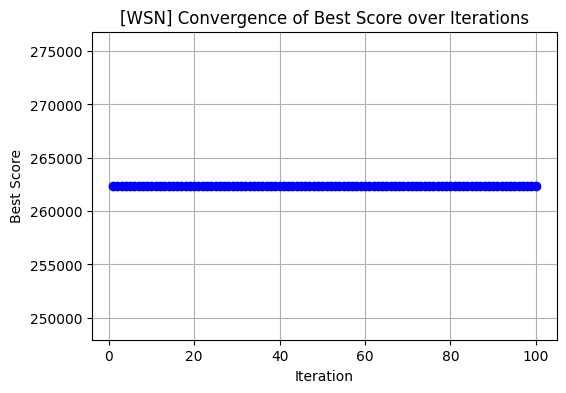

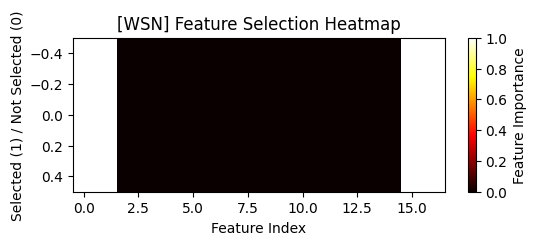



Mean Best Score: 262379.99999999994
Standard Deviation of Best Score: 5.820766091346741e-11
Mean Classification Accuracy: 0.6978713522718477
Standard Deviation of Classification Accuracy: 0.0033346895437904598



In [7]:
# Trial 49 finished with value: 393569.2021983125 and parameters: {'c1': 1.849482609021072, 'c2': 0.8783506458821368, 'swarm_size': 19}. Best is trial 45 with value: 65594.3215496555.
# Best Hyperparameters: {'c1': 0.6700432133061096, 'c2': 0.6865350301907676, 'swarm_size': 47}


best_position, best_score, best_scores_over_time = PSOVA1(features, labels, 0.6700432133061096, 0.6865350301907676, 100, 47)
mean_accuracy, std_accuracy = calculate_accuracy(features, labels, best_position)

# Calculate mean and standard deviation of best scores
mean_score = np.mean(best_scores_over_time)
std_score = np.std(best_scores_over_time)

# Visualization of best score over iterations
print("")
print("="*110)
plt.figure(figsize=(6, 4))
plt.plot(range(1, max_iter + 1), best_scores_over_time, marker='o', color='b')
plt.xlabel('Iteration')
plt.ylabel('Best Score')
plt.title('[WSN] Convergence of Best Score over Iterations')
plt.grid()
plt.show()

# Visualize best position in a feature heatmap
plt.figure(figsize=(6, 2))
plt.imshow(best_position.reshape(1, -1), cmap='hot', aspect='auto')
plt.colorbar(label='Feature Importance')
plt.title('[WSN] Feature Selection Heatmap')
plt.xlabel('Feature Index')
plt.ylabel('Selected (1) / Not Selected (0)')
plt.show()

# Print results
print("")
print("="*110)
print("")
print("Mean Best Score:", mean_score)
print("Standard Deviation of Best Score:", std_score)
print("Mean Classification Accuracy:", mean_accuracy)
print("Standard Deviation of Classification Accuracy:", std_accuracy)
print("")
print("="*110)


In [8]:
features_col = df.columns.to_list()
selected_features = [features_col[i] for i in range(len(best_position)) if best_position[i] == 1]
non_selected_features = [features_col[i] for i in range(len(best_position)) if best_position[i] == 0]

print(f"Selected Features:\n{selected_features}")
print(f"Non-Selected Features:\n{non_selected_features}")


Selected Features:
[' id', ' Time', ' dist_CH_To_BS', ' send_code ']
Non-Selected Features:
[' Is_CH', ' who CH', ' Dist_To_CH', ' ADV_S', ' ADV_R', ' JOIN_S', ' JOIN_R', ' SCH_S', ' SCH_R', 'Rank', ' DATA_S', ' DATA_R', ' Data_Sent_To_BS']
